### LSTM for time series forecast

- Long short-term memory recurrent neural networks are capable of automatically learning features from sequence data, and can output a variable
length sequences that can be used for multi-step forecasting. 

#### This notebook shows how to use an Encoder-Decoder LSTM With Univariate Input for time series forecast. 

### Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras import metrics

In [6]:
no2 = pd.read_csv("dati/NO2.csv")
no2.head()

,datetime,NO2 (Biossido di azoto)
0,2020-01-01 00:00:00,16.0
1,2020-01-01 1:00:00,26.0
2,2020-01-01 2:00:00,25.0
3,2020-01-01 3:00:00,24.0
4,2020-01-01 4:00:00,32.0


In [5]:
no2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6935 entries, 0 to 6934
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 6935 non-null   object 
 1   NO2 (Biossido di azoto)  6935 non-null   float64
dtypes: float64(1), object(1)
memory usage: 108.5+ KB


In [7]:
no2['datetime'] = pd.to_datetime(no2['datetime'])

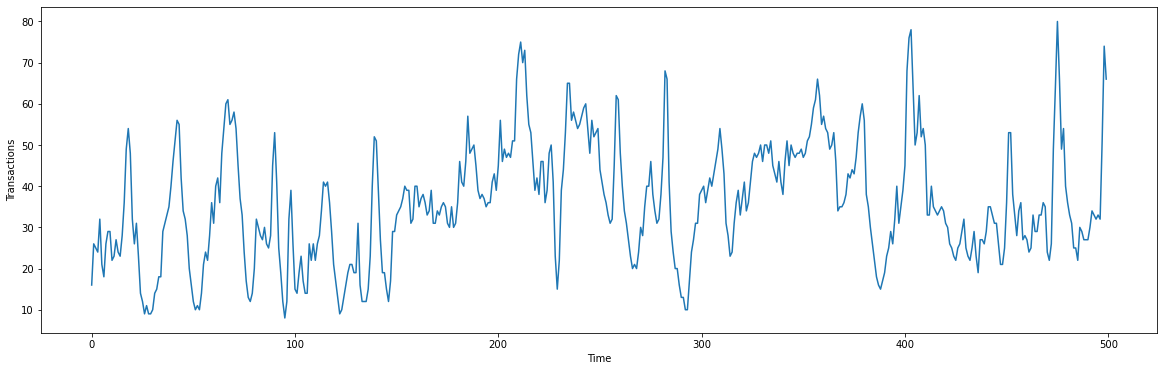

In [11]:
plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")
plt.plot(no2['NO2 (Biossido di azoto)'][:500])
plt.show()

### Prepare the data for the neural network

In [16]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
         # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
         # check if we are beyond the sequence
         if out_end_ix > len(sequence):
             break
         # gather input and output parts of the pattern
         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

series  = no2['NO2 (Biossido di azoto)'].values

# choose a number of time steps
n_steps_in, n_steps_out = 24, 24

# split into samples
X, y = split_sequence(series, n_steps_in, n_steps_out)
count = 0
for i in range(len(X)):
    print(X[i], y[i])
    count +=1
    if count>5: break

[16. 26. 25. 24. 32. 21. 18. 26. 29. 29. 22. 23. 27. 24. 23. 28. 36. 49.
 54. 48. 32. 26. 31. 23.] [14. 12.  9. 11.  9.  9. 10. 14. 15. 18. 18. 29. 31. 33. 35. 40. 46. 51.
 56. 55. 42. 34. 32. 28.]
[26. 25. 24. 32. 21. 18. 26. 29. 29. 22. 23. 27. 24. 23. 28. 36. 49. 54.
 48. 32. 26. 31. 23. 14.] [12.  9. 11.  9.  9. 10. 14. 15. 18. 18. 29. 31. 33. 35. 40. 46. 51. 56.
 55. 42. 34. 32. 28. 20.]
[25. 24. 32. 21. 18. 26. 29. 29. 22. 23. 27. 24. 23. 28. 36. 49. 54. 48.
 32. 26. 31. 23. 14. 12.] [ 9. 11.  9.  9. 10. 14. 15. 18. 18. 29. 31. 33. 35. 40. 46. 51. 56. 55.
 42. 34. 32. 28. 20. 16.]
[24. 32. 21. 18. 26. 29. 29. 22. 23. 27. 24. 23. 28. 36. 49. 54. 48. 32.
 26. 31. 23. 14. 12.  9.] [11.  9.  9. 10. 14. 15. 18. 18. 29. 31. 33. 35. 40. 46. 51. 56. 55. 42.
 34. 32. 28. 20. 16. 12.]
[32. 21. 18. 26. 29. 29. 22. 23. 27. 24. 23. 28. 36. 49. 54. 48. 32. 26.
 31. 23. 14. 12.  9. 11.] [ 9.  9. 10. 14. 15. 18. 18. 29. 31. 33. 35. 40. 46. 51. 56. 55. 42. 34.
 32. 28. 20. 16. 12. 10.]
[21. 18. 2

#### Prepare training and test set. 

In [17]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [18]:
train_size = int(len(X) * 0.75)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]
print(len(train_X), len(train_y), len(test_X), len(test_y))

5166 5166 1722 1722


#### Define the neural network model.

In [25]:
# define model
model = Sequential()
model.add(LSTM(40, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(RepeatVector(n_steps_out))
model.add(LSTM(40, activation='relu', return_sequences=True)) 
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse',metrics=[metrics.mae, 'mae'] )
# fit model
history = model.fit(train_X, train_y, epochs=40, verbose=2)

Epoch 1/40
162/162 - 5s - loss: 265.9884 - mean_absolute_error: 11.3412 - mae: 11.3412
Epoch 2/40
162/162 - 2s - loss: 377.4683 - mean_absolute_error: 9.5341 - mae: 9.5341
Epoch 3/40
162/162 - 2s - loss: 142.6498 - mean_absolute_error: 8.6595 - mae: 8.6595
Epoch 4/40
162/162 - 2s - loss: 1131.2322 - mean_absolute_error: 10.5572 - mae: 10.5572
Epoch 5/40
162/162 - 2s - loss: 154.5529 - mean_absolute_error: 8.8873 - mae: 8.8873
Epoch 6/40
162/162 - 2s - loss: 146.2939 - mean_absolute_error: 8.7056 - mae: 8.7056
Epoch 7/40
162/162 - 2s - loss: 142.2678 - mean_absolute_error: 8.6192 - mae: 8.6192
Epoch 8/40
162/162 - 3s - loss: 139.5830 - mean_absolute_error: 8.5524 - mae: 8.5524
Epoch 9/40
162/162 - 3s - loss: 137.9363 - mean_absolute_error: 8.5122 - mae: 8.5122
Epoch 10/40
162/162 - 2s - loss: 136.4018 - mean_absolute_error: 8.4719 - mae: 8.4719
Epoch 11/40
162/162 - 2s - loss: 134.6826 - mean_absolute_error: 8.4160 - mae: 8.4160
Epoch 12/40
162/162 - 2s - loss: 131.9129 - mean_absolute_

In [26]:
history.history

{'loss': [265.9884033203125,
  377.46832275390625,
  142.64984130859375,
  1131.232177734375,
  154.5528564453125,
  146.29385375976562,
  142.26783752441406,
  139.58303833007812,
  137.9363250732422,
  136.4017791748047,
  134.68264770507812,
  131.91294860839844,
  130.08827209472656,
  128.92416381835938,
  128.01846313476562,
  126.99259948730469,
  125.45547485351562,
  124.72830963134766,
  123.92314910888672,
  123.66473388671875,
  122.79443359375,
  122.87834167480469,
  121.4828109741211,
  121.16114044189453,
  149.2725067138672,
  171.68006896972656,
  130.59796142578125,
  127.71356964111328,
  125.59050750732422,
  129.22373962402344,
  123.17613983154297,
  122.1478500366211,
  123.62173461914062,
  122.5508041381836,
  121.81340789794922,
  120.67520904541016,
  119.93914794921875,
  120.22337341308594,
  119.63246154785156,
  120.02729034423828],
 'mean_absolute_error': [11.341180801391602,
  9.534135818481445,
  8.659473419189453,
  10.557154655456543,
  8.8872909545

### Plot training history

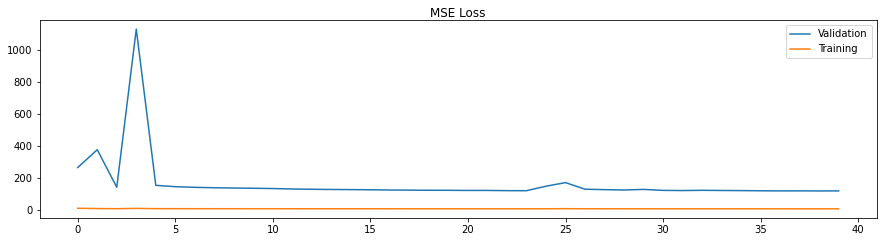

In [27]:
# plot loss learning curves
plt.figure(figsize = (15, 8))
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='Validation') 
plt.plot(history.history['mean_absolute_error'], label='Training')
plt.legend()


### Show the first prediction using the model that you already trained

In [28]:
# demonstrate prediction
x_input = np.array([  16., 26., 25., 24., 32., 21., 18., 26., 29. ,29., 22., 23. ,27., 24., 23., 28. ,36., 49.,
                       54. ,48., 32., 26. ,31., 23.])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[27.389072]
  [25.721   ]
  [26.432531]
  [26.999464]
  [29.578484]
  [31.607363]
  [31.124035]
  [28.625639]
  [29.573347]
  [30.043036]
  [30.035324]
  [30.042656]
  [30.473637]
  [30.919844]
  [30.90332 ]
  [30.899864]
  [31.156675]
  [31.730589]
  [32.389725]
  [32.990173]
  [33.536064]
  [34.036743]
  [34.499653]
  [34.931618]]]


Mean Absolute Error =  7.516006074600611


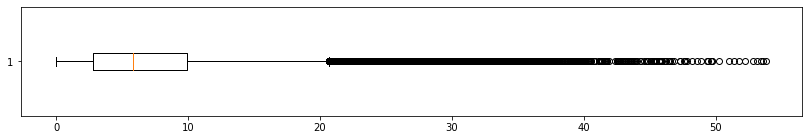

In [29]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    # x_input = X[i].reshape((1, n_steps))
    x_input = test_X[i].reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    predicted = np.append(predicted, yhat[0]) 


expected = test_y
expected = np.reshape(expected, (expected.shape[0]*expected.shape[1]))
# abs difference
difference = abs((expected - predicted))

print('Mean Absolute Error = ', np.mean(difference))
# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert= False);
plt.show()